# Notebook #2: Optimization of the sine waveform

This Jupyter Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird [[1]](#1).

This notebook contains the code to perform the optimization of a sine waveform as a forcing signal for dynamic catalysis. Since the sine wave is a continuous function, the gradient-based L-BFGS-B method was used, along with the derivative-free methods Nelder-Mead and Powell for comparison, all within `scipy.minimize.optimize` [[2]](#2). Additionally, Notebook #7 brings the optimization of the sine wave with a modified framework from the simulation, using Pyomo.DAE [[3]](#3) and IPOPT [[4]](#4), in which wave parameters are decision variables.

The representation of the optimal sinewaveform found within bounds is shows in **Figure S4b**. Please see following code, comments and narrative text to understand and use the workflow.

## Install Pyomo and IPOPT on Google Colab

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

## Importing necessary libraries from Python and Pyomo

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param,
                           SolverFactory, value, sin, cos, Set,
                           TransformationFactory, assert_optimal_termination, exp, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from scipy import signal
from tqdm import tqdm 
import time
import idaes
from scipy.optimize import minimize

## Declaring parameter values

In [2]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """
    
    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6, 
                        beta = 100,
                        gamma = 2, 
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        nfe = 900
                        ):
        
        
        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Rg_constants  = Rg_constants # Gas constant used in kinetic constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated 
        self.nfe = nfe # Number of discretization points

## Calculate the periodic kinetic constants from the forcing signal for binding energies 

In [3]:
def time_dependent_params(params, t):
    """
    Calculates rate constants from the periodic binding energy of A
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Munch callables for the rate constants
    """
    
    # Parameters as given in the class
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    amplitude = params.amplitude # Amplitude of the wave (decision variable)
    offset = params.offset # Offset of the wave: determines the values of binding energy of A (decision variable)
    freq_osci = params.freq_osci # Frequency of the wave (decision variable)
    
    # Binding energy calculation (eV)
    # Oscillation in sine waveform
    BEa = amplitude * np.sin(2 * np.pi * 1 * t) + offset
        
    # Binding energy values for B, from the linear relationship with Bea   
    BEb = gamma * BEa + H2 / F - gamma * H1 / F + (1 - gamma) * delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa * F # For the adsorption step
    delH2 = (H2 - BEb * F) - (H1 - BEa * F) # For the surface reaction step
    delH3 = BEb * F # For the desorption step

    # Activation energy from BEP relationship (kJ/mol)
    Ea = alpha * delH2 + beta

    # Gibbs free energy  
    delG1 = delH1 - T * delS1 * 0.001 # For the adsorption step
    delG2 = delH2 - T * delS2 * 0.001 # For the surface reaction step
    delG3 = delH3 - T * delS3 * 0.001 # For the desorption step

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1 / Rg_constants / T) # For the adsorption step
    K2 = np.exp(-delG2 / Rg_constants / T) # For the surface reaction step 
    K3 = np.exp(-delG3 / Rg_constants / T) # For the desorption step

    # Kinetic constants (1/s)
    kf1 = ((kB * T)/hp) * np.exp(delS1 * 0.001 / Rg_constants) # For the adsorption of A
    kf2 = ((kB * T) / hp) * np.exp(-Ea / Rg_constants / T) # For the forward surface reaction
    kr3 = ((kB * T) / hp) * np.exp(-delS3 * 0.001 / Rg_constants) # For the adsorption of B
    kr1 = kf1 / K1 # For the desorption of A
    kr2 = kf2 / K2 # For the reverse surface reaction
    kf3 = kr3 * K3 # For the desorption of B
    
    return Munch(kf1 = kf1, kf2 = kf2, kf3 = kf3, kr1 = kr1, kr2 = kr2, kr3 = kr3, BEa = BEa)

## Create the Pyomo model

In [4]:
def create_pyomo_model(params):
    """
    Creates the pyomo model for the CSTR. Uses Backwards Finite Difference method to discretize the time span and 
    a system of equations from the ODE system modelled here. 
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Discretized Pyomo model
    """

    # Parameters as given in the class
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    amplitude = params.amplitude
    N = params.N
    V = params.V
    offset = params.offset
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    number_periods = params.number_periods
    nfe = params.nfe
    
    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params
    
    # Create time span
    # Scaling time to be between 0 and 1 
    m.tau = ContinuousSet(bounds=(0, 1)) 
    # True time span, dependent of tau
    m.times = Var(m.tau) 
    
    # Parameter fir the final time to be equal the number of periods times the wave period 
    m.tf = Param(initialize = params.number_periods*1/params.freq_osci)
    
    # Define variables- concentrations varying with time, 
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, initialize = 2.84)
    m.Cb = Var(m.tau, initialize = 0.1)
    m.thetaA = Var(m.tau, initialize = 0.5)
    m.thetaB = Var(m.tau, initialize = 0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times) # For time scaling
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)

    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf
    
    # Declare ODEs as contraints

    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function 
        pt = time_dependent_params(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        # Multiply the final time for time scaling
        return m.dCadt[t] == m.tf * ((q / V) * (Caf - m.Ca[t]) \
            - pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po * (N / V) + pt.kr1 * m.thetaA[t] * (N / V))

    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((q / V) * (Cbf - m.Cb[t]) \
            + (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po) * (N / V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po \
            - pt.kr1 * m.thetaA[t] - pt.kf2 * m.thetaA[t] + pt.kr2 * m.thetaB[t])
    
    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((pt.kf2 * m.thetaA[t] - pt.kr2 * m.thetaB[t]) \
            - (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po))

    # Declare discretization method and parameters 
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe = nfe, scheme='BACKWARD')
    
    # Return the model
    return m

## Solving the model and calculating avTOF from the results

In [5]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Values of turnover frequency in each point in time and value of the time-averaged turnover frequency
    """
        
    # Get the Pyomo model
    m = create_pyomo_model(params)
    
    # Key part of the simultaneous approach
    # Equality constraints for initial and final points - to enforce periodicity 
    # and direct simulation of cyclic steady state
    m.CaCSS = Constraint(expr = m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
    m.CbCSS = Constraint(expr = m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
    m.thetaACSS = Constraint(expr = m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
    m.thetaBCSS = Constraint(expr = m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

    # Call IPOPT as solver for the square system
    solver = SolverFactory('ipopt')
    status = solver.solve(m, tee = tee)
    # If solving in a loop, terminate runs when unable to solve
    assert_optimal_termination(status)

    # Attributing values
    Ca = [value(m.Ca[t]) for t in m.tau]
    Cb = np.asarray([value(m.Cb[t]) for t in m.tau])
    thetaA = [value(m.thetaA[t]) for t in m.tau]
    thetaB = [value(m.thetaB[t]) for t in m.tau]
    theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.tau]

    # Calculating TOF from the concentration of product on the gas phase
    TOF = Cb * params.q / params.N
        
    # Calculating the time-average by integration with the trapezoid method/ mean value theorem
    avTOF = np.trapz(TOF, m.tau) 
    
    return [TOF, avTOF]

## Applying the optimization methods

The optimize.minimize function in the library Scipy [[2]](#2) is used to identify which values for the three parameters of the sine wave, frequency, amplitude, and offset, lead to the higher value of time-averaged turnover frequency (avTOF). The only type of constraints in the problem are the bounds of the values, which were chosen mainly based in the lines-over-volcano representation and in values previously used in the simulations that seem plausible for the forcing signal for this system.

In [6]:
# Get the parameters values from the class
params = Params()
    
# Define the objective function, which will receive the decision variables and parameters
def obj(decision_vars, params):
    freq, amp, offset = decision_vars
    params.freq_osci = freq
    params.amplitude = amp
    params.offset = offset
    
    TOF, avTOF = tof_from_decision_vars(params, tee=False)
    # The minus signal for the response will make the result to be for maximization, and not minimization
    return - avTOF
# A lambda function is used to create a function that takes the decision variables and gives avTOF
fun = lambda decision_vars: obj(decision_vars, params)

# The initial guess is given. Several values were tested and they lead to similar optimal results
# The order is frequency, amplitude, offset
initial_guess = (500, 0.3, 1.3)

# Bounds are given for the search space
# The order once again is frequency, amplitude, offset
bnds=[(100, 1500), (0.2, 0.4), (1.2, 1.5)]

# The callback function allows for printing the results in each iteration of the method
def callback(values):
    avTOF_value = obj(values, params)
    print(f'Frequency = {values[0]}, amplitude = {values[1]} eV,\
offset = {values[2]} eV, avTOF = {-avTOF_value} Hz')

In [7]:
results = []
elapsed_times = []

methods = ['L-BFGS-B', 'Nelder-Mead', 'Powell']

for method in methods:
    
    # Time for reaching solution is measured
    start_time = time.time()

    # The result is given by using the minimize function with the selected method
    # The low tolerance guarantees convergence to the maximum
    # disp = True generates the output of total number of iterations and function evaluations
    result = minimize(fun, x0 = initial_guess, bounds = bnds, method = method, tol = 1e-8, options = {'disp': True}, callback = callback)

    frequency = result.x[0]
    amplitude = result.x[1]
    offset = result.x[2]
    max_avTOF = -result.fun
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    
    results.append(result)
    
    print(f'With {method} method, frequency = {frequency}, amplitude = {amplitude}, offset = {offset}, maximum avTOF = {max_avTOF}, given in {elapsed_time:1.2f} seconds.')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90430D+01    |proj g|=  2.00000D-01

At iterate    1    f= -2.81509D+02    |proj g|=  2.42823D-01
Frequency = 500.00094125072906, amplitude = 0.37141172401059636 eV,offset = 1.4428234480211928 eV, avTOF = 281.5094218217432 Hz

At iterate    2    f= -2.81788D+02    |proj g|=  2.44712D-01
Frequency = 500.00109573286386, amplitude = 0.37235609617254717 eV,offset = 1.4447121923450945 eV, avTOF = 281.7877182663918 Hz

At iterate    3    f= -4.00300D+02    |proj g|=  3.48592D-01
Frequency = 499.9350588230524, amplitude = 0.4 eV,offset = 1.458693293517458 eV, avTOF = 400.30035238745415 Hz

At iterate    4    f= -4.13511D+02    |proj g|=  5.20572D-01
Frequency = 499.91994190881223, amplitude = 0.4 eV,offset = 1.4467319540796917 eV, avTOF = 413.51077732907083 Hz

At iterate    5    f= -4.14663D+02    |pro

In [11]:
for i, result in zip(methods, results):
    
    print(f'With {i} method, frequency = {result.x[0]:1.2f}, amplitude = {result.x[1]:1.2f} eV, \
offset = {result.x[2]:1.2f} eV, maximum avTOF = {-result.fun:1.2f} s-1.')

With L-BFGS-B method, frequency = 1500.00, amplitude = 0.40 eV, offset = 1.44 eV, maximum avTOF = 569.52 s-1.
With Nelder-Mead method, frequency = 1500.00, amplitude = 0.40 eV, offset = 1.44 eV, maximum avTOF = 569.52 s-1.
With Powell method, frequency = 1500.00, amplitude = 0.40 eV, offset = 1.44 eV, maximum avTOF = 569.52 s-1.


## Checking for agreement in the results with different methods

If the results with different methods do not agree, this might be a sign of numerical issues, sensitivity to the initial guesses or bounds given, or the existence of multiple maxima in the problem. The notebook is set to use as optimal the decision variable values that lead to the higher avTOF, but it is worth it to check for these possible issues and try to correct them. 

In [12]:
if all(abs(results[i].x[w] - results[j].x[w]) < 1e-1 for i, j, w in [(0, 1, 0), (0, 1, 1), (0, 1, 2)]) \
    and all(abs(results[i].x[w] - results[j].x[w]) < 1e-1 for i, j, w in [(0, 2, 0), (0, 2, 1), (0, 2, 2)]) \
    and all(abs(results[i].fun - results[j].fun) < 2 for i, j in [(0, 1), (0, 2)]):
    
    opt_frequency = results[0].x[0]
    opt_amplitude = results[0].x[1]
    opt_offset = results[0].x[2]
    max_avTOF = -results[0].fun
    
    print(f'Optimal decision variables: frequency = {opt_frequency:1.2f} Hz, \
amplitude = {opt_amplitude:1.2f} eV, offset = {opt_offset:1.2f} eV, maximum avTOF = {max_avTOF:1.2f} s-1.')
    
else:
    print('Optimal values found with different methods do not match within tolerance.\
 Possibly, there are multiple maxima within bounds. The conditions that lead to the higher avTOF are selected.')
    
    max_avTOF = np.max([-results[0].fun, -results[1].fun, -results[2].fun])
    index = [-results[0].fun, -results[1].fun, -results[2].fun].index(max_avTOF)  
    opt_frequency = results[index].x[0]
    opt_amplitude = results[index].x[1]
    opt_offset = results[index].x[2]
    
    print(f'Optimal decision variables: frequency = {opt_frequency:1.2f} Hz, \
amplitude = {opt_amplitude:1.2f} eV, offset = {opt_offset:1.2f} eV, maximum avTOF = {max_avTOF:1.2f} s-1.')

Optimal decision variables: frequency = 1500.00 Hz, amplitude = 0.40 eV, offset = 1.44 eV, maximum avTOF = 569.52 s-1.


## Plots of optimal waveform and avTOF result

The plot below shows the format of the optimal waveform found, in orange, and the TOF change in dashed blue for one period.

In [13]:
# Use as parameters the optimal values found
params.freq_osci = opt_frequency
params.amplitude = opt_amplitude
params.offset = opt_offset

# Gettings TOF array for plotting
TOF, avTOF = tof_from_decision_vars(params, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

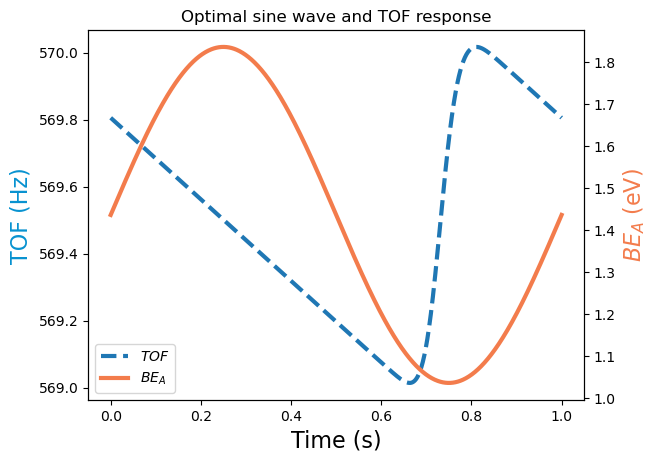

In [14]:
# Returning the model to be able to get BE of A values
m = create_pyomo_model(params)

# Getting BE of A values for plotting
def be(m,t):
    pt = time_dependent_params(params, t)  
    Be_a = pt.BEa
    return Be_a

BEa_array = []
for t in m.times:
    bea = be(m, t)
    BEa_array.append(bea)

# Creating the two plots in the same frame
fig, ax1 = plt.subplots()

# Creating the first plot: times x TOF plot
ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle = '--')
ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=16)

# Creating the second plot: times x BEa with axes on the right side
ax2 = ax1.twinx()
ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower left')
ax2.set_title('Optimal sine wave and TOF response');

## Bibliography

<a id="1">1. link to our paper
    
<a id="2">2. P. Virtanen, R. Gommers, T. E. Oliphant, M. Haberland, T. Reddy, D. Cournapeau, E. Burovski, P. Peterson, W. Weckesser, J. Bright, S.J. van der Walt, J. Brett, M.and Wil-
son, K. J. Millman, N. Mayorov, A. R. J. Nelson, E. Jones, R. Kern, E. Larson, C. J. Carey,
 ̇I Polat, Y. Feng, E. W. Moore, J. VanderPlas, D. Laxalde, J. Perktold, Ro. Cimrman, I. Hen-
riksen, E. A. Quintero, C. R. Harris, A. M. Archibald, A. H. Ribeiro, F. Pedregosa, P. van
Mulbregt, and SciPy 1.0 Contributors. SciPy 1.0: Fundamental Algorithms for Scientific
Computing in Python. Nature Methods, 17:261–272, 2020.
    
<a id="3">3. B. Nicholson, J. D. Siirola, J. Watson, V. M. Zavala, and L. T. Biegler. pyomo.dae: a mod-
eling and automatic discretization framework for optimization with differential and algebraic
equations. Mathematical Programming Computation, 10(2):187–223, 2018.
    
<a id="4">4. A. W achter and L. Biegler. On the implementation of an interior-point filter line-search
algorithm for large-scale nonlinear programming. Mathematical Programming, 106:25–57, 2006.